In [195]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import datetime
import pickle
import time
import re

import os
import rasterio
import shapely.geometry
import scipy.ndimage as ndimage

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [196]:
#from sklearn.cluster import dbscan

In [197]:
output_dir = "/home/ubuntu/data/TX_paired/"

In [198]:
#first time only
#load geo_pandas DataFrame
#geo_df = pickle.load( open( output_dir+"GeoDataFrame_fine.pickled", "rb" ))
#geo_df['bad_image']=None
#geo_df['problem']=None
#geo_df['verified']=None
#if resuming:

geo_df = pickle.load( open( output_dir+"GeoDataFrame_fine_turked.pickled", "rb" ))


geo_df.set_index("tile_no")
geo_df.head(2)

tile_no  flooded    post-storm_full    pre-storm_full post-storm_resized  \
0       0  0.80323  0_post_resize_img  0_pre_resize_img    0_post_full_img   
1       1   0.8787  1_post_resize_img  1_pre_resize_img    1_post_full_img   

  pre-storm_resized course_mask_full course_mask_resized fine_mask_filename  \
0    0_pre_full_img           0_mask       0_resize_mask    0_256_fine_mask   
1    1_pre_full_img           1_mask       1_resize_mask    1_256_fine_mask   

     footprint dry_or_wet                                          mask_poly  \
0  3002220.tif        wet  (POLYGON ((-95.57181511210993 29.4410615808823...   
1  3002220.tif        wet  POLYGON ((-95.56764981800494 29.44136752727207...   

                                      tile_transform  \
0  [222822.4, 0.0, 0.0, -222822.4, 21295616.0, 65...   
1  [222822.4, 0.0, 0.0, -222822.4, 21295104.0, 65...   

                                            geometry        DBScan  \
0  POLYGON ((-95.56985294117646 29.44106158088235...  0_256_DBSCAN   
1  POLYGON ((-95.56755514705883 29.44106158088235...  1_256_DBSCAN   

           DBScan_gauss bad_image problem verified  
0  0_256_fine_mask_blur      None    None    False  
1  1_256_fine_mask_blur      None    None     True

In [199]:
#fix some formatting problems and typos
#note: full and resized images are backwards
geo_df.rename(columns = {'%flooded':'flooded','dry/wet':'dry_or_wet','fine_make_filename':'fine_mask_filename'}, inplace=True)
geo_df.head(4)

tile_no   flooded    post-storm_full    pre-storm_full post-storm_resized  \
0       0   0.80323  0_post_resize_img  0_pre_resize_img    0_post_full_img   
1       1    0.8787  1_post_resize_img  1_pre_resize_img    1_post_full_img   
2       2  0.864578  2_post_resize_img  2_pre_resize_img    2_post_full_img   
3       3  0.576237  3_post_resize_img  3_pre_resize_img    3_post_full_img   

  pre-storm_resized course_mask_full course_mask_resized fine_mask_filename  \
0    0_pre_full_img           0_mask       0_resize_mask    0_256_fine_mask   
1    1_pre_full_img           1_mask       1_resize_mask    1_256_fine_mask   
2    2_pre_full_img           2_mask       2_resize_mask    2_256_fine_mask   
3    3_pre_full_img           3_mask       3_resize_mask    3_256_fine_mask   

     footprint dry_or_wet                                          mask_poly  \
0  3002220.tif        wet  (POLYGON ((-95.57181511210993 29.4410615808823...   
1  3002220.tif        wet  POLYGON ((-95.56764981800494 29.44136752727207...   
2  3002220.tif        wet  (POLYGON ((-95.5654521647227 29.44106158088235...   
3  3002220.tif        wet  (POLYGON ((-95.56505909959365 29.443359375, -9...   

                                      tile_transform  \
0  [222822.4, 0.0, 0.0, -222822.4, 21295616.0, 65...   
1  [222822.4, 0.0, 0.0, -222822.4, 21295104.0, 65...   
2  [222822.4, 0.0, 0.0, -222822.4, 21294592.0, 65...   
3  [222822.4, 0.0, 0.0, -222822.4, 21294080.0, 65...   

                                            geometry        DBScan  \
0  POLYGON ((-95.56985294117646 29.44106158088235...  0_256_DBSCAN   
1  POLYGON ((-95.56755514705883 29.44106158088235...  1_256_DBSCAN   
2  POLYGON ((-95.56525735294117 29.44106158088235...  2_256_DBSCAN   
3  POLYGON ((-95.56295955882354 29.44106158088235...  3_256_DBSCAN   

           DBScan_gauss bad_image problem verified  
0  0_256_fine_mask_blur      None    None    False  
1  1_256_fine_mask_blur      None    None     True  
2  2_256_fine_mask_blur      None    None     True  
3  3_256_fine_mask_blur      True       c     True

### Restart from here if re-doing bad tiles, etc.

In [207]:
#get tile_no for those tiles with more than a little flooding
t = geo_df["flooded"] >= 0.00
sum(t)
tiles = geo_df[t].tile_no
print(len(tiles))

4405


In [208]:
#take out tiles already checked
t = (geo_df["verified"] != True)*(geo_df["footprint"] != '2131133.tif')*(geo_df["footprint"] != '3020020.tif')*(geo_df["footprint"] != '3020002.tif')*(geo_df["footprint"] != '3002220.tif')*(geo_df["footprint"] != '2131131.tif')
print(sum(t))
tiles = geo_df[t].tile_no
print(len(tiles))

2250
2250


In [209]:
tiles.values[0:20]

array([491, 1017, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825,
       1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834], dtype=object)

In [210]:
#prep sub-function for re-writing masks
def re_write_mask(num,DBScan_mask,tile_no):
    c_id = int(num)
    fine_mask = 1*(DBScan_mask==c_id)
    
    #blur mask using gaussian filter and save that too.  was 1.3
    DBmask_blur = ndimage.gaussian_filter(255*fine_mask, sigma=(1.5, 1.5), order=0)
    threshold = 0.3
    if c_id == -1:  threshold = 0.8
    DBmask_blurred = DBmask_blur> 255*threshold
    np.save(output_dir+"%d_256_fine_mask_blur"%tile_no, DBmask_blurred)
    
    plt.subplots(1, 1, figsize=(5,5))
    plt.title("Gaussian Smoothed Mask of Selected Cluster")
    plt.imshow(DBmask_blurred,cmap='GnBu')
    print("re-mask to cluster number %d",c_id)
    return

In [211]:
#prep sub-function for re-writing masks, this one for combining multiple
def re_write_mask_multiple(num_list,DBScan_mask,tile_no):
    threshold = 0.3
    
    print("combining clusters",num_list)
    blank_mask = np.zeros(img_post.shape[0:2],dtype='int64')
    
    fine_mask = blank_mask
    
    for num in num_list:
        c_id = int(num)
        if c_id == 9:
            print("group 9 mapped to -1 and threshold increased")
            c_id = -1
            threshold = 0.8
        print(c_id)
        fine_mask = (DBScan_mask==c_id) + fine_mask
        plt.subplots(1, 1, figsize=(5,5))
        plt.imshow(fine_mask,cmap='GnBu')
        plt.show()
    
    fine_mask = 1* (fine_mask > 0)  # in case the masks were to overlap..
    
    #blur mask using gaussian filter and save that too.  was 1.3
    DBmask_blur = ndimage.gaussian_filter(255*fine_mask, sigma=(1.5, 1.5), order=0)
    
    DBmask_blurred = DBmask_blur> 255*threshold
    np.save(output_dir+"%d_256_fine_mask_blur"%tile_no, DBmask_blurred)

    plt.subplots(1, 1, figsize=(5,5))
    plt.title("Gaussian Smoothed Mask of Selected Clusters")
    plt.imshow(DBmask_blurred,cmap='GnBu')
    print("re-mask to cluster number %d",c_id)
    return

('working on tile #:', 491)


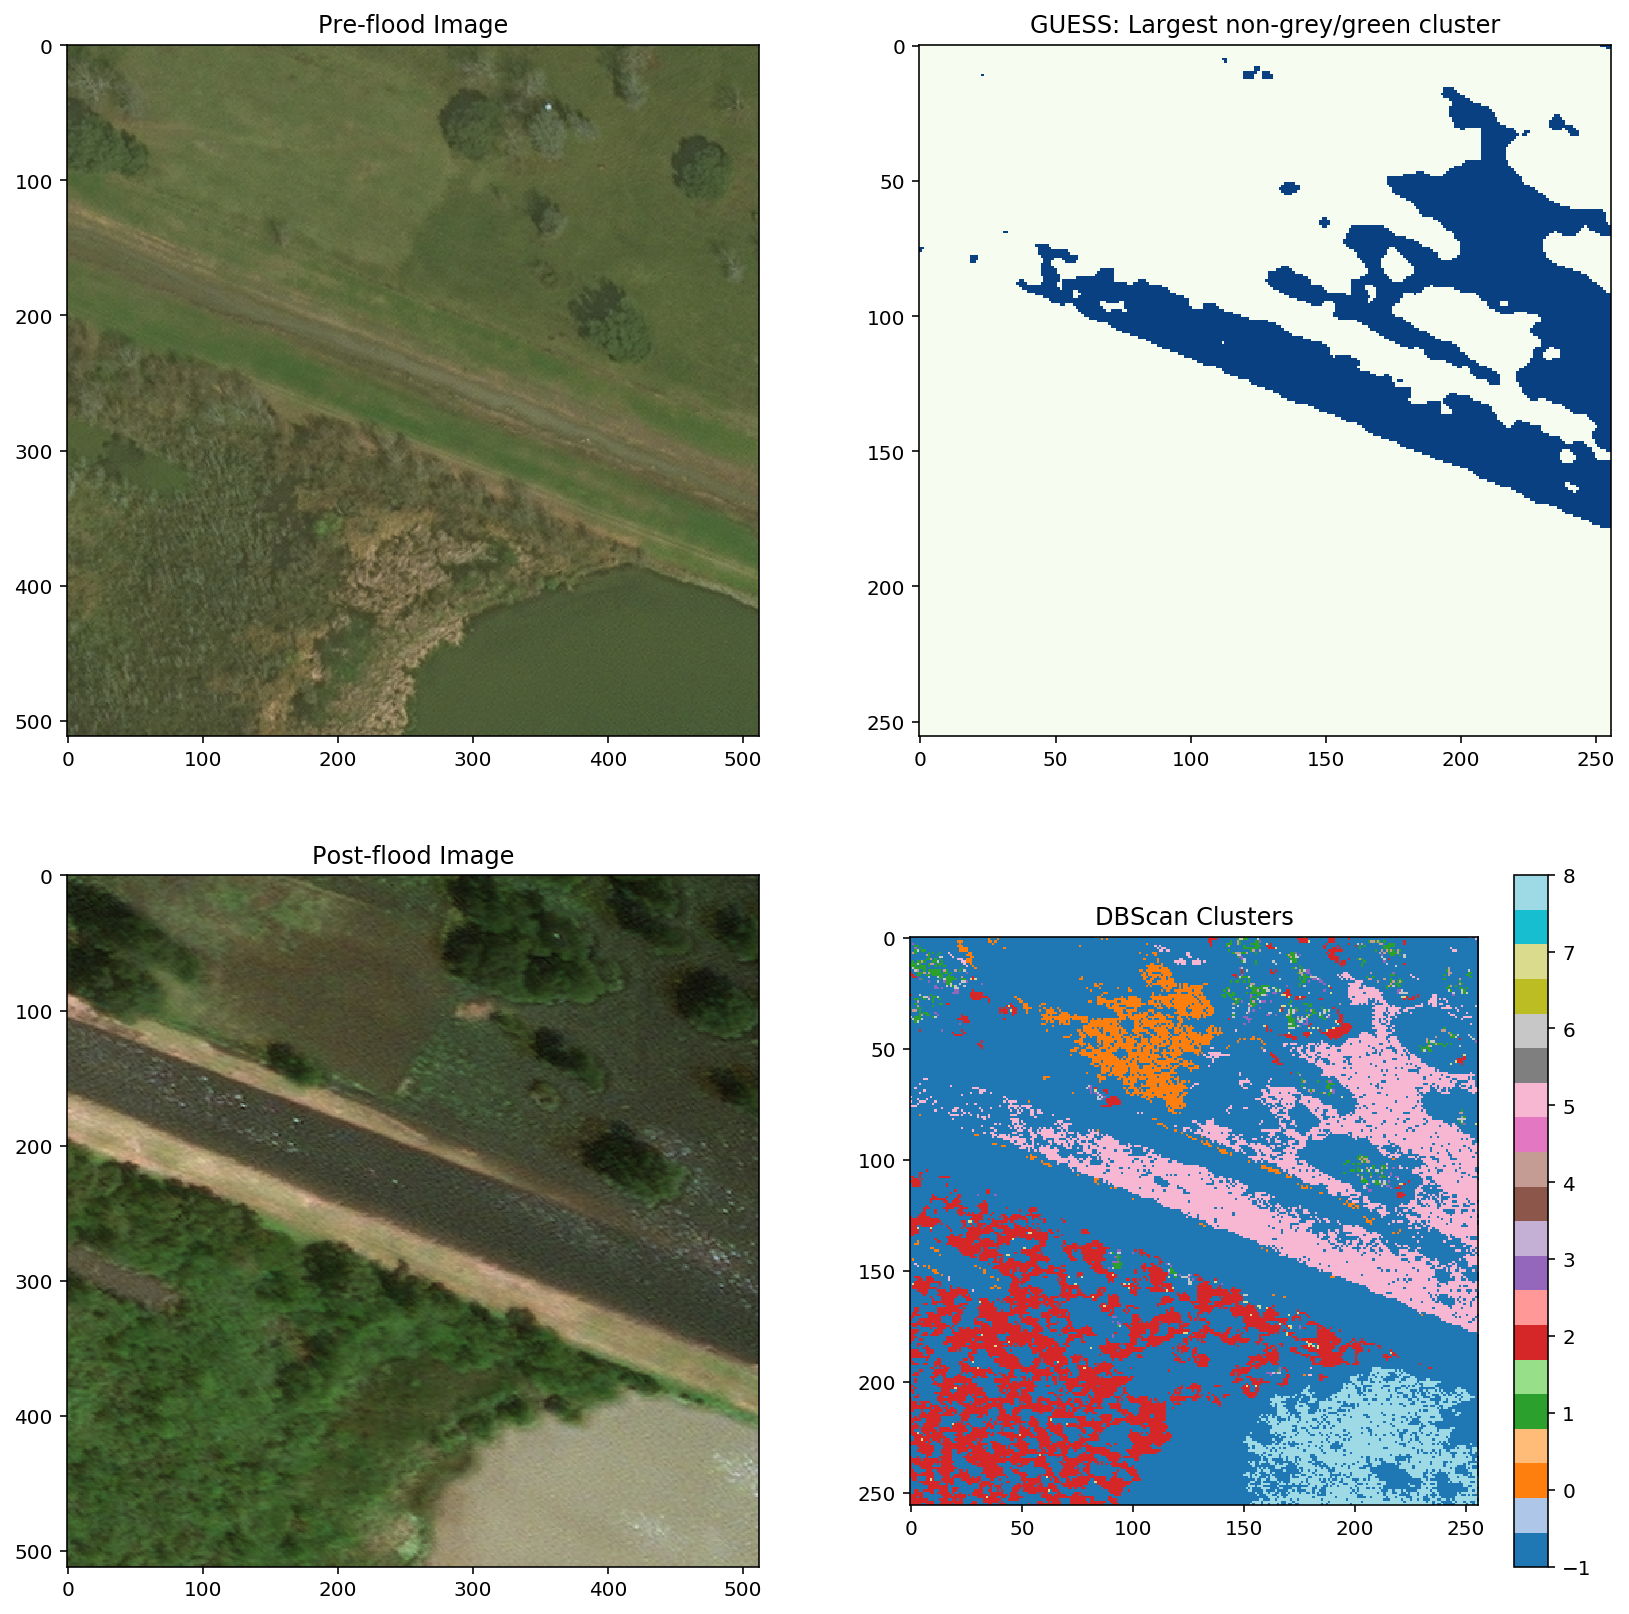

580
('combining clusters', [5, 8, 0])
5


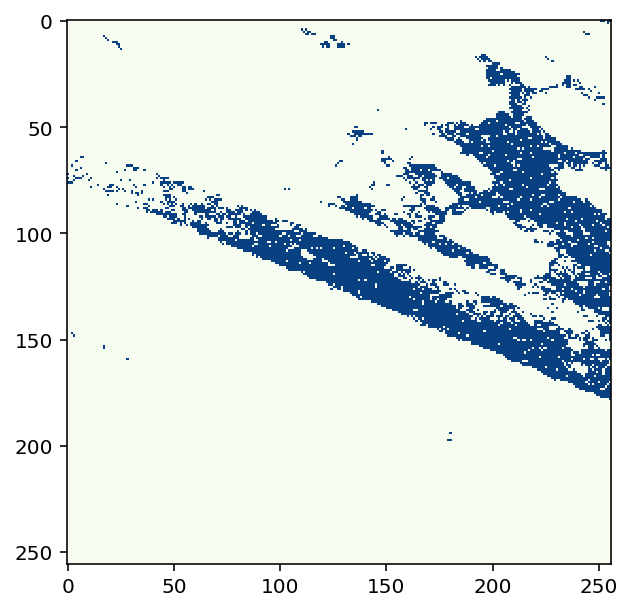

8


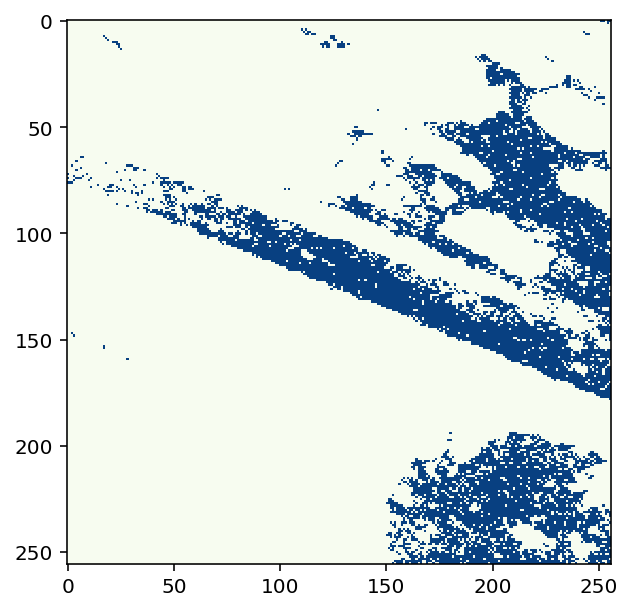

0


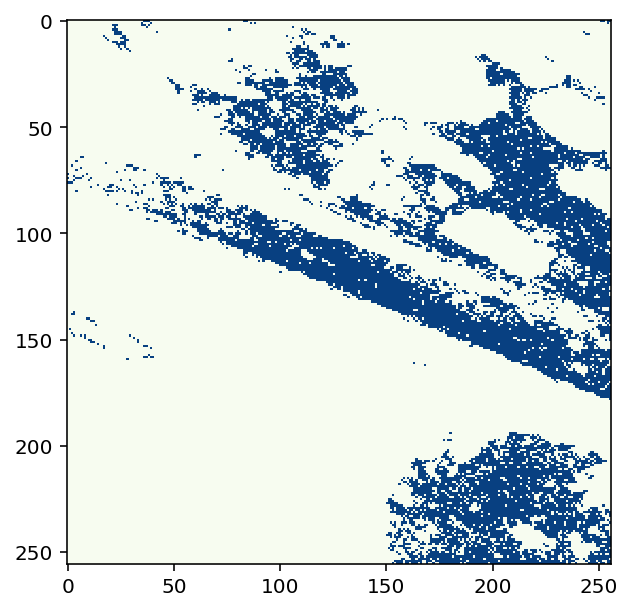

('re-mask to cluster number %d', 0)
('working on tile #:', 1017)


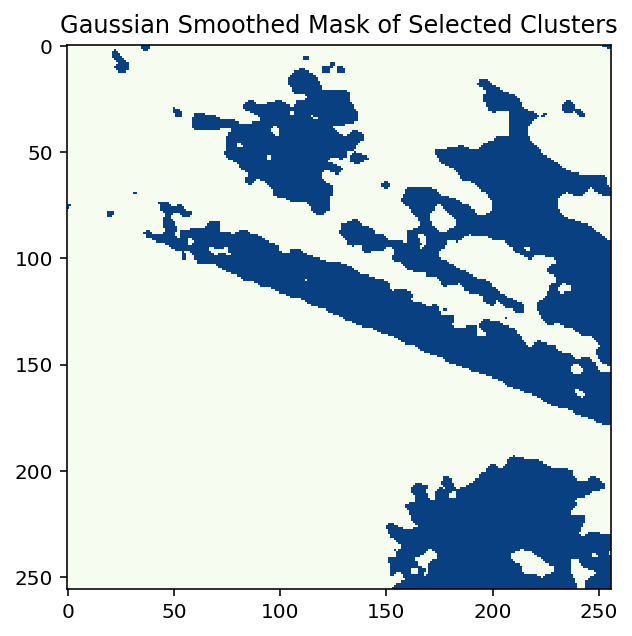

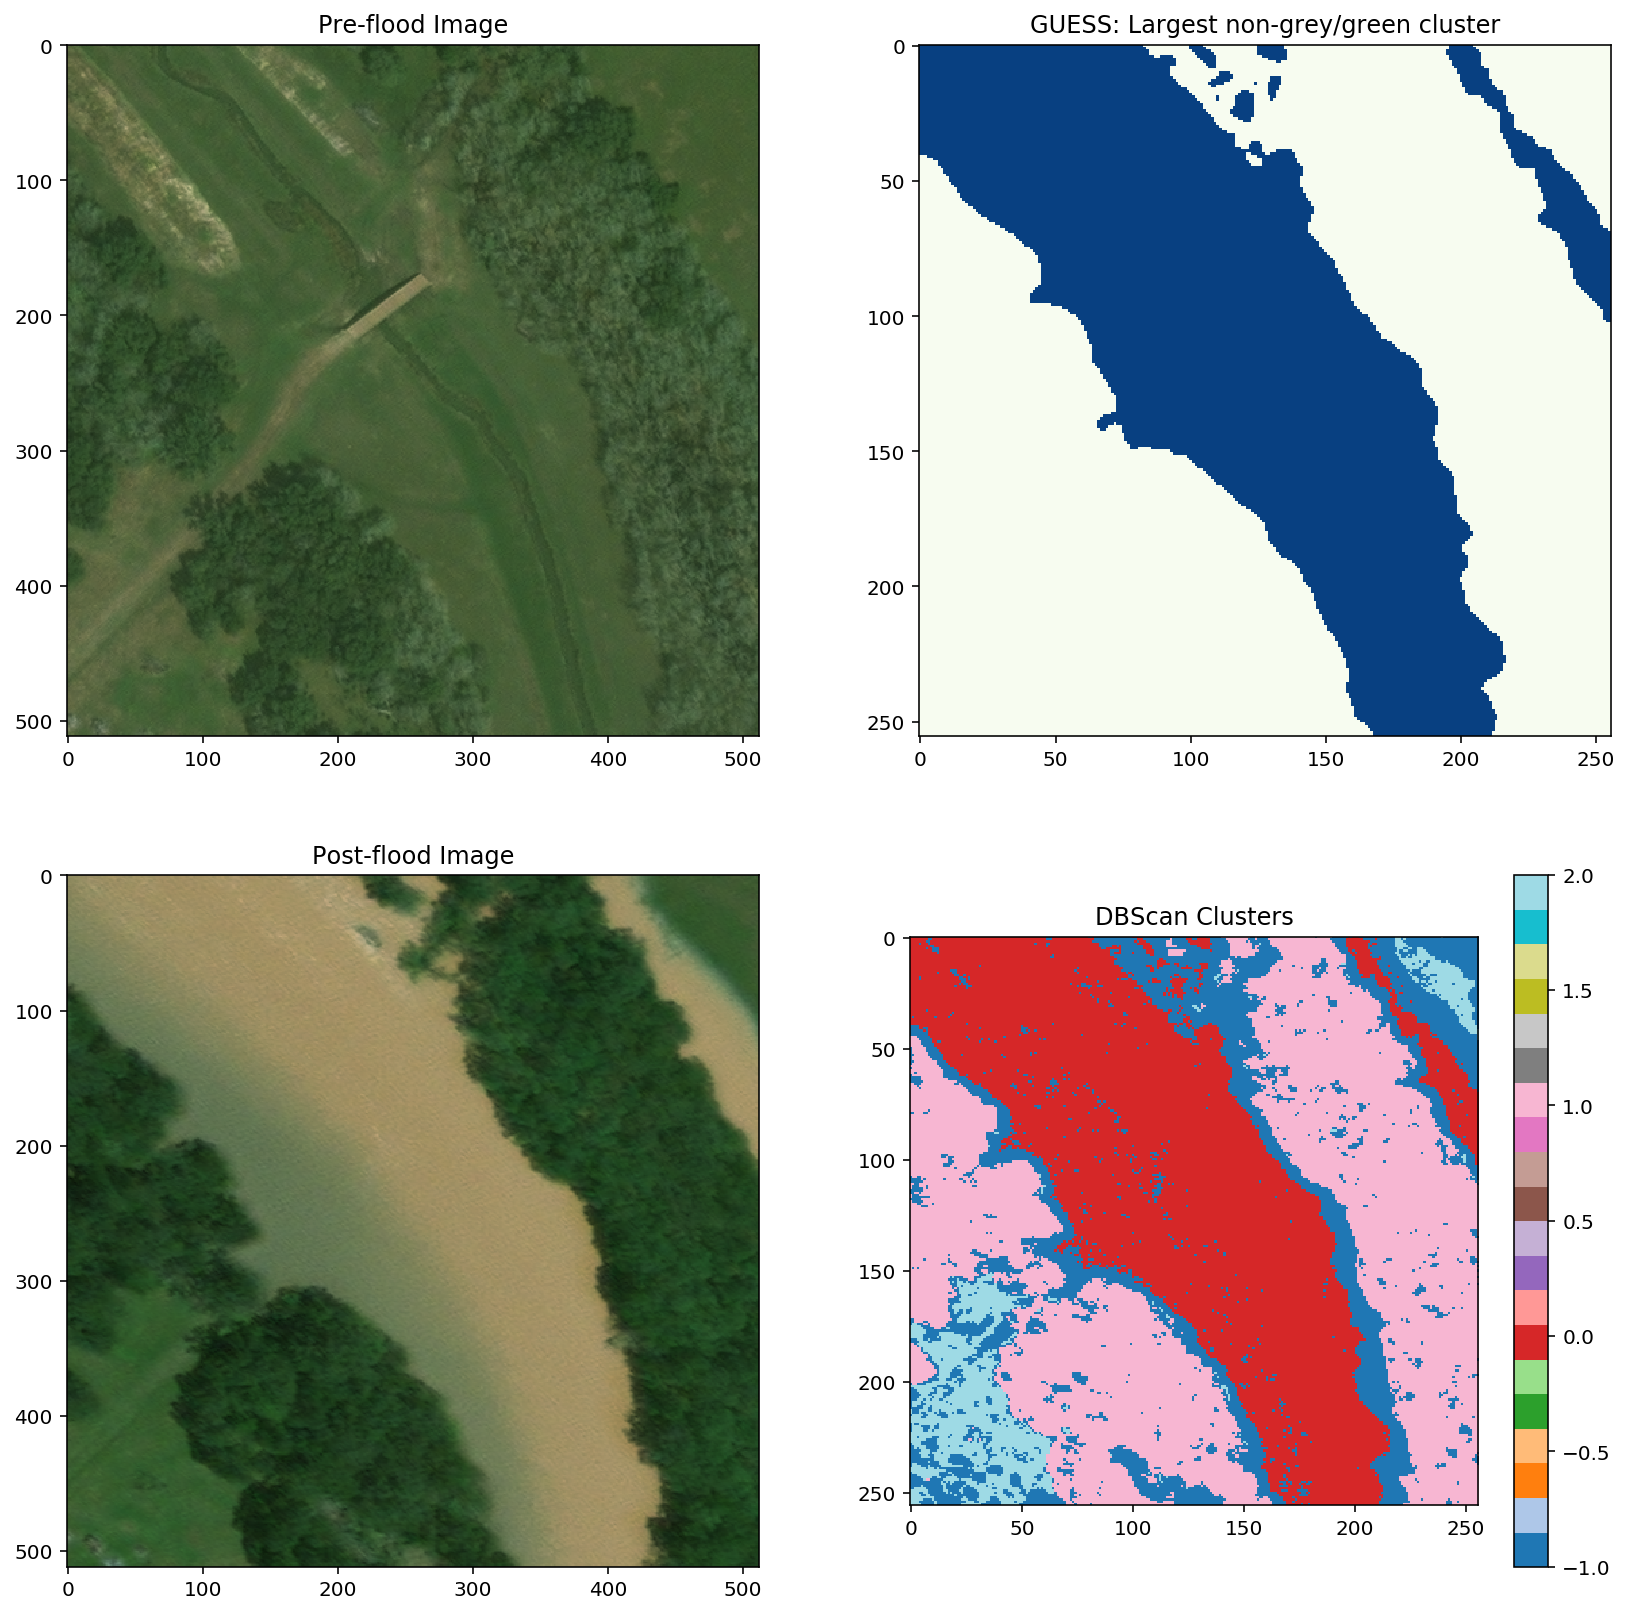

209
('combining clusters', [2, 0, 9])
2


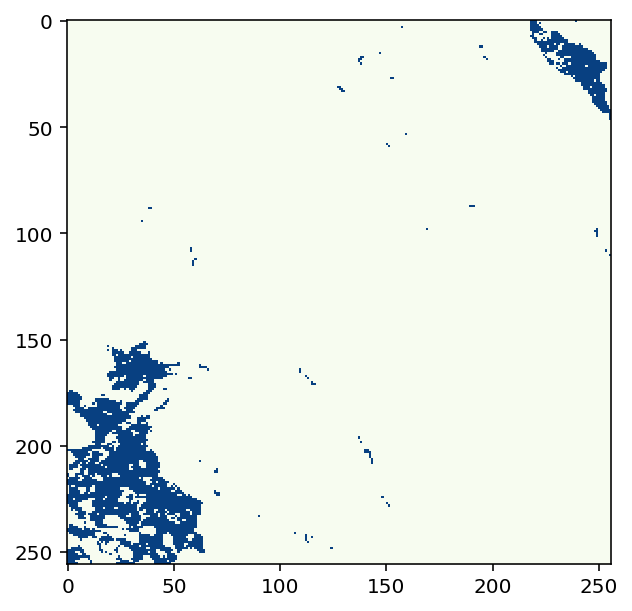

0


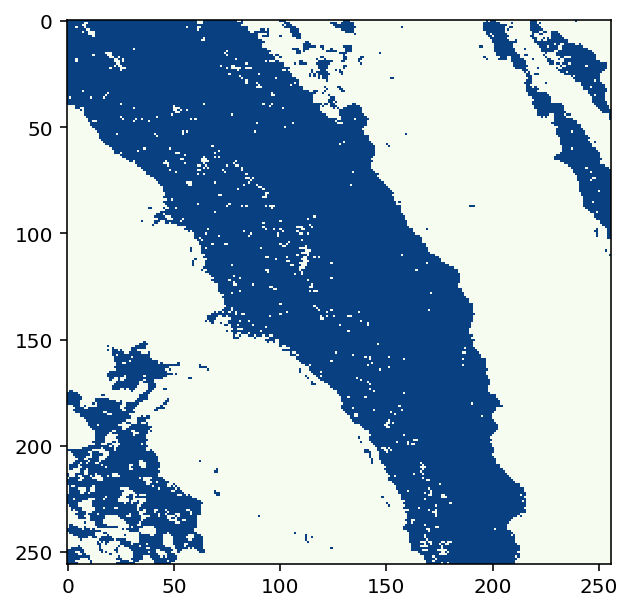

group 9 mapped to -1 and threshold increased
-1


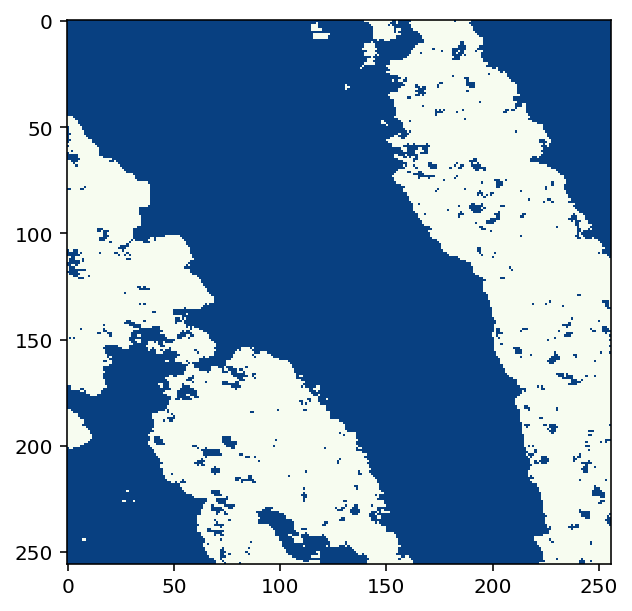

('re-mask to cluster number %d', -1)
('working on tile #:', 1817)


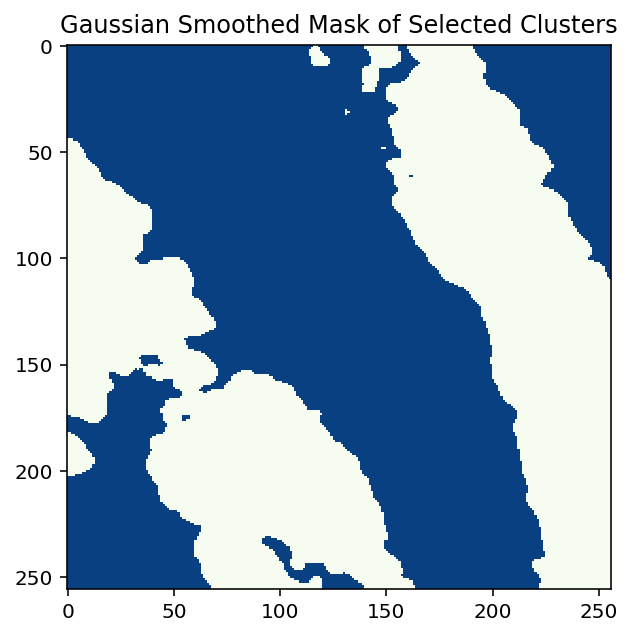

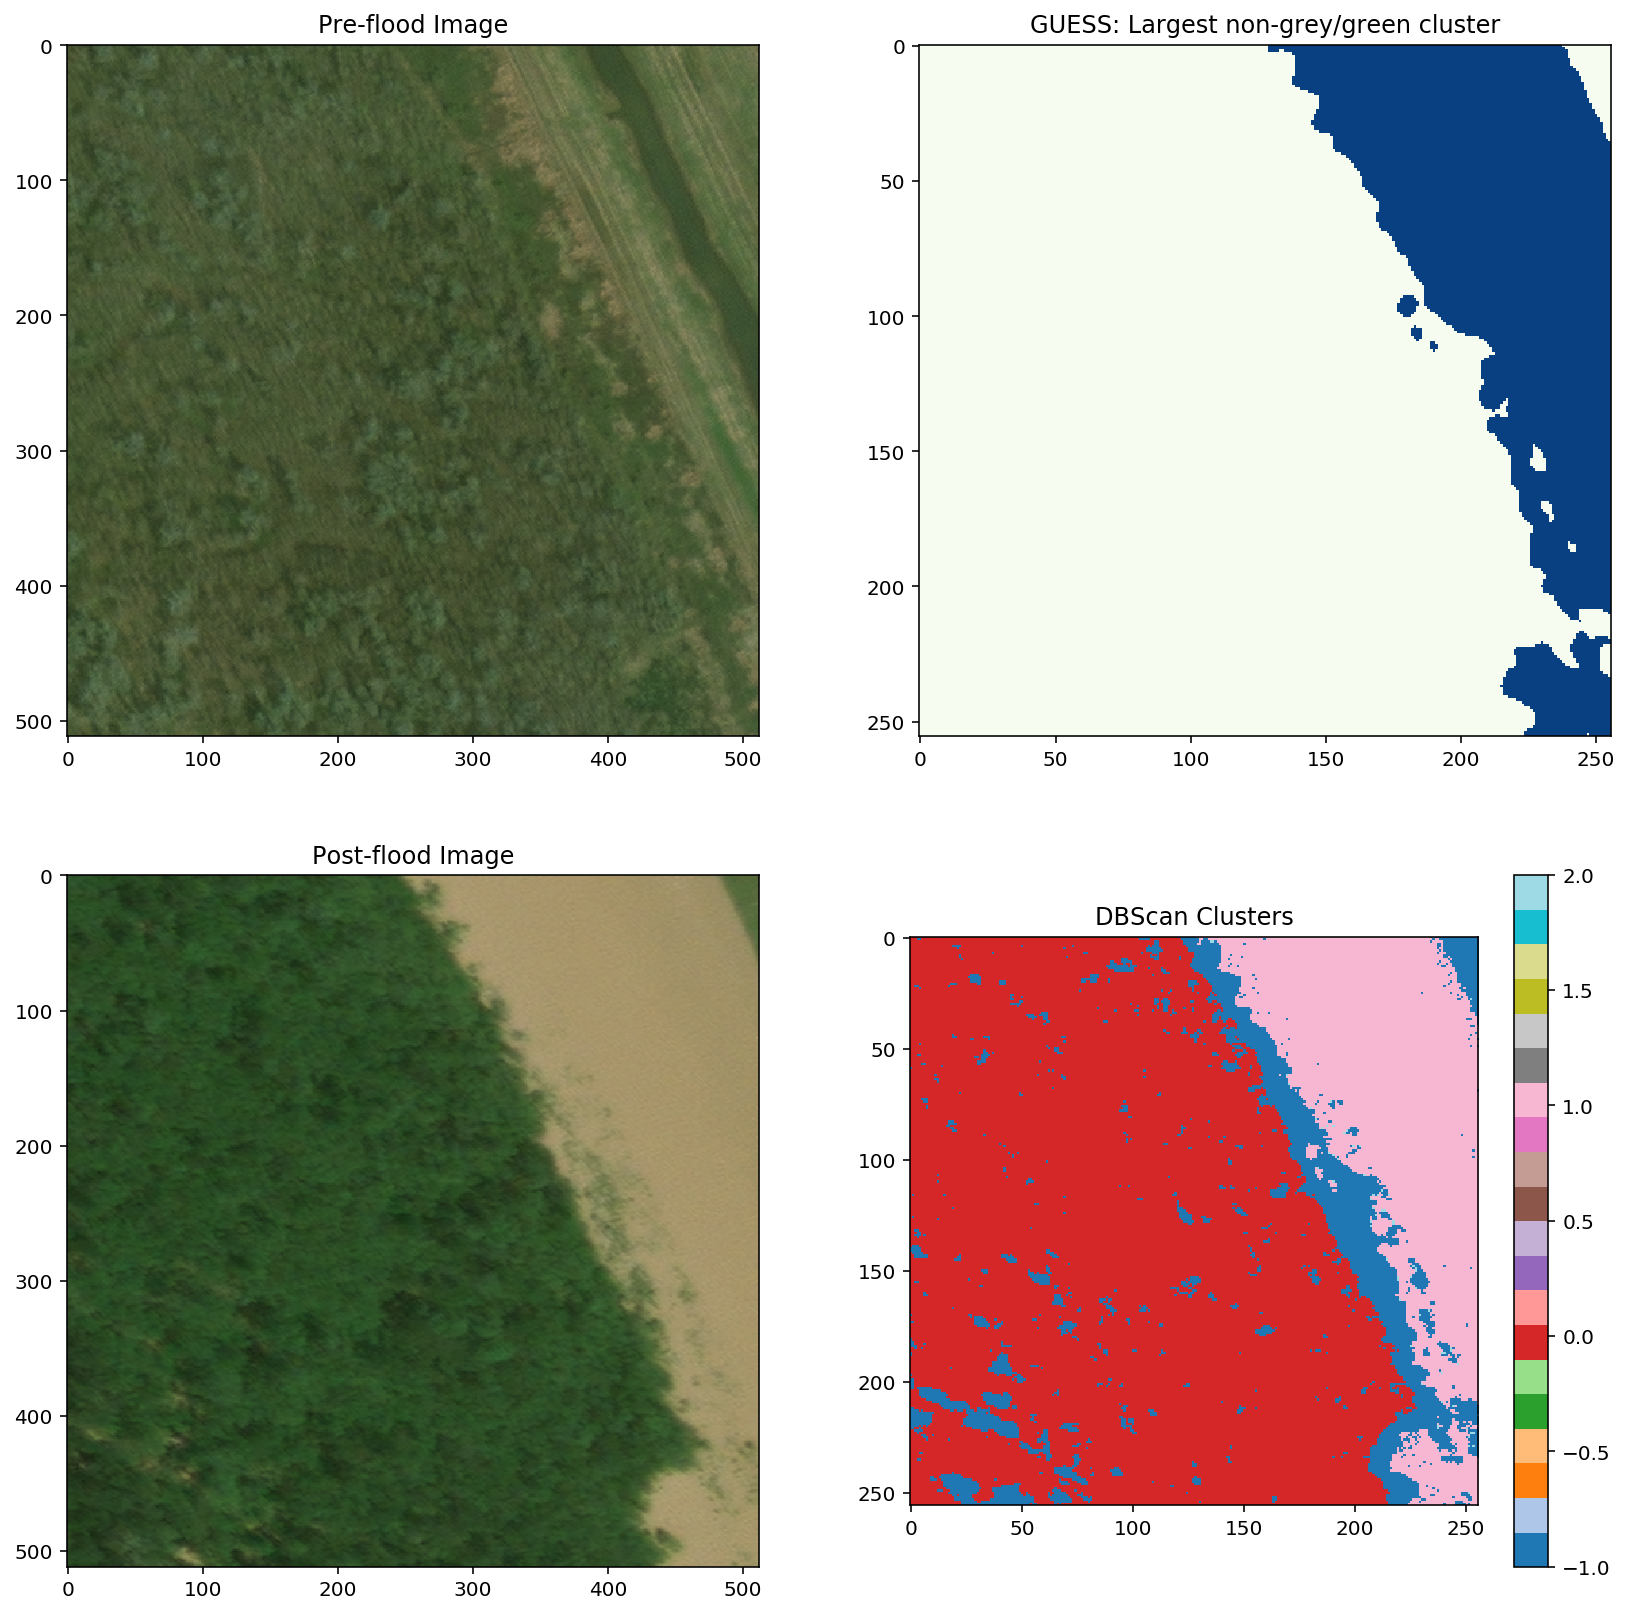

skip
('working on tile #:', 1818)


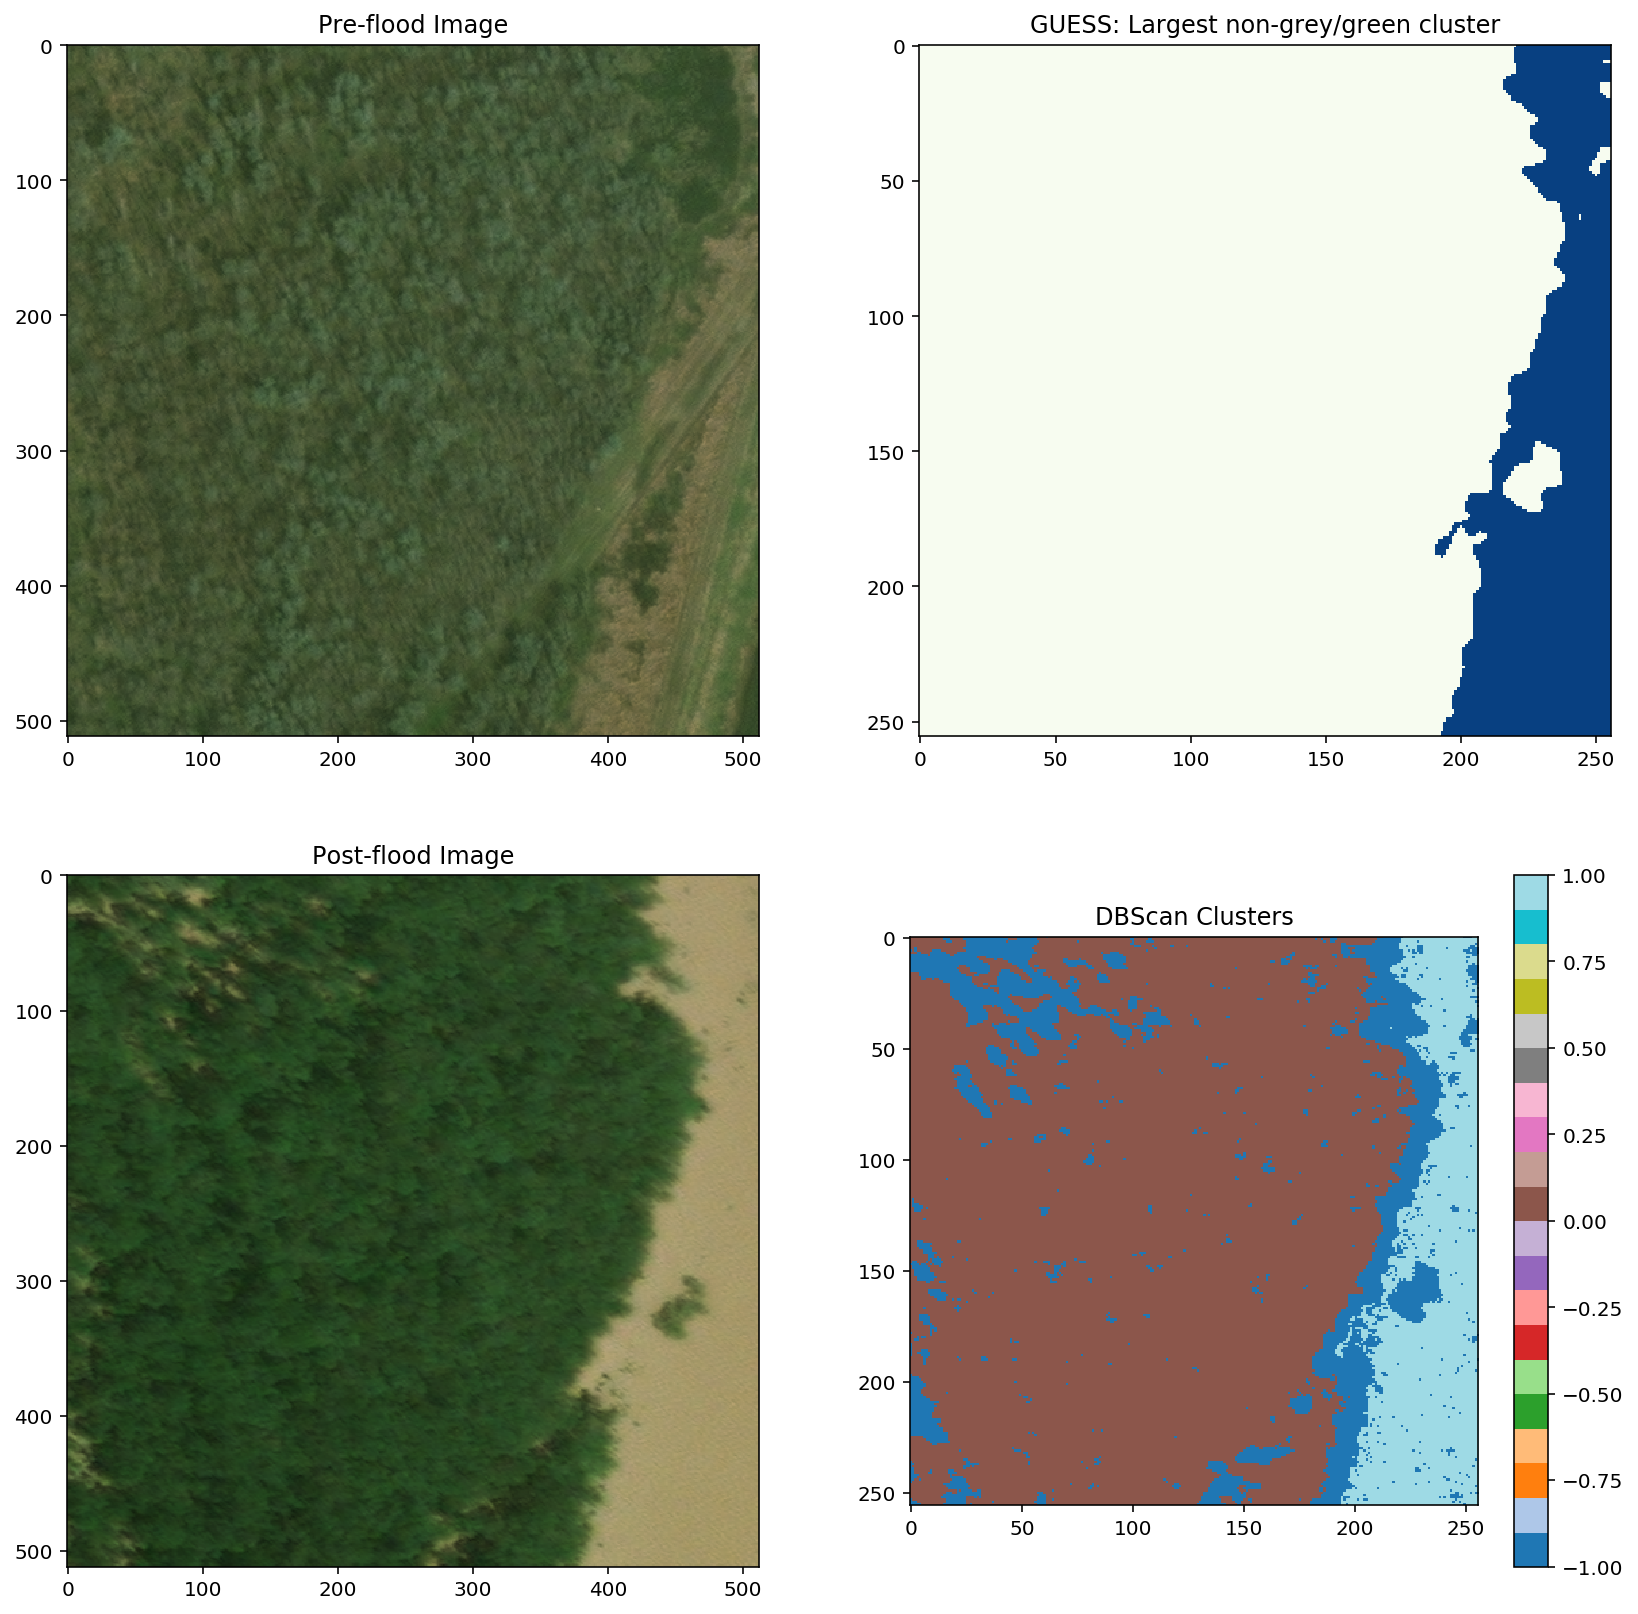

skip
('working on tile #:', 1819)


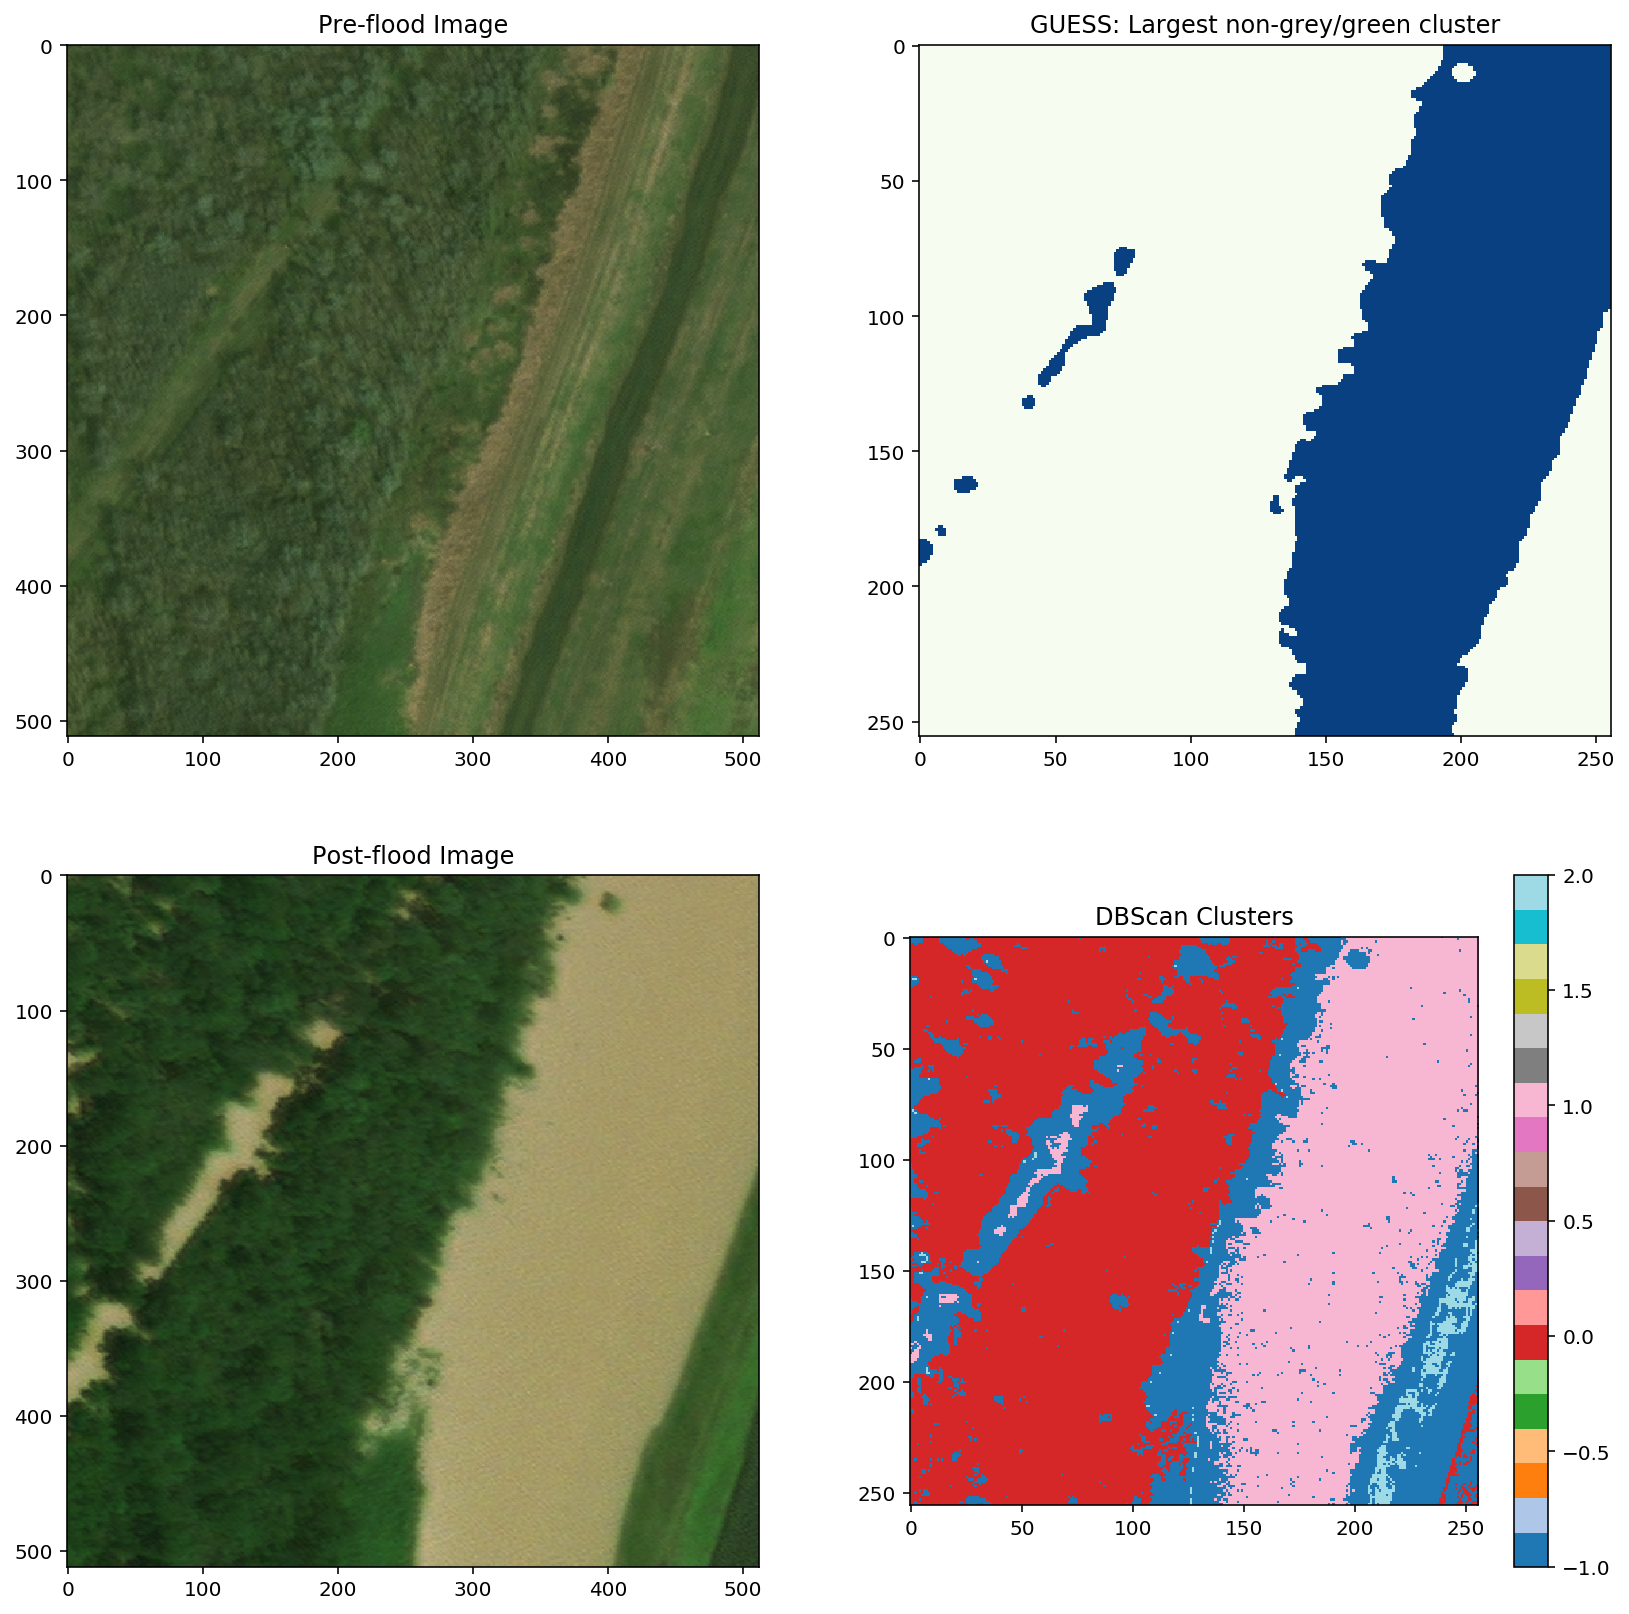

KeyboardInterrupt: 

In [212]:
#run a subset of data at a time in case DBSCAN kills the kernel
m=0
for tile_no in tiles.values:
    print("working on tile #:",tile_no)
    
    #load files
    img_post = np.load(output_dir+'%d_post_resize_img.npy'%tile_no)
    img_post_full  = np.load(output_dir+'%d_post_full_img.npy'%tile_no)
    img_pre  = np.load(output_dir+'%d_pre_full_img.npy'%tile_no)
    #mask = np.load(output_dir+'%d_resize_mask.npy'%tile_no)
    fine_mask = np.load(output_dir+'%d_256_fine_mask_blur.npy'%tile_no)
    #DBScan cluster map
    DBScan_mask = np.load(output_dir+'%d_256_DBSCAN.npy'%tile_no)
        
    #plot for inspection and approval/adjustment/rejection
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(14,14))
    ax3.set_title("Post-flood Image")
    #ax2.set_title("Post-flood Image w/ mask")
    ax1.set_title("Pre-flood Image")
    ax2.set_title("GUESS: Largest non-grey/green cluster")
    ax4.set_title("DBScan Clusters")
    #ax1.set_title("Flood Water removed")
    #ax1.imshow(img_post)
    ax3.imshow(img_post_full)
    #ax2.imshow(img_post)
    #ax2.imshow(fine_mask,cmap='inferno',alpha = 0.3)
    ax1.imshow(img_pre)
    ax2.imshow(fine_mask,cmap='GnBu')
    plt.imshow(DBScan_mask,cmap='tab20')
    plt.colorbar()
    plt.show();
    #print("percent D.G. flooding labeled: %d"%geo_df.flooded[tile_no])
    
    #prep blank mask
    blank_mask = np.zeros(img_post.shape[0:2],dtype='int64')
    
    #wait while plots show, then prompt user for what to do with the image/mask
    time.sleep(0.1)
    
    #skip input for bad images or those already done
    if geo_df.bad_image[tile_no]==True or geo_df.verified[tile_no]==True:
        bad_input = True
    else: bad_input = True
        
    while bad_input == True:
        bad_input = False
        a = raw_input()
        a = str(a)
    
        if   a == 'g': print("tile_no %d approved!"%tile_no)
            
        elif a == 'b': #treat file as bad
            probtext = str(raw_input())
            if probtext == "oops":
                bad_input=True
                continue
            geo_df.bad_image[tile_no] = True
            geo_df.problem[tile_no] = str(probtext)
            
        elif a == 'd': #treat guess as dry, and write blank mask
            geo_df.dry_or_wet[tile_no] = 'dry'
            np.save(output_dir+"%d_256_fine_mask_blur"%tile_no, blank_mask)
            np.save(output_dir+"%d_256_fine_mask"%tile_no, blank_mask)
            
        elif a == 'skip': break
         
        elif a == '0': #set mask cluster to 'n' and re-write mask,  same for 1,2,3,4,5,6...
            re_write_mask(a,DBScan_mask,tile_no)
        elif a == '1': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '2': re_write_mask(a,DBScan_mask,tile_no)    
        elif a == '3': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '4': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '5': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '6': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '7': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '8': re_write_mask(a,DBScan_mask,tile_no)
        #elif a == '9': re_write_mask(a,DBScan_mask,tile_no)
        elif a == '-1': re_write_mask(a,DBScan_mask,tile_no)
            
        elif len(re.findall(r'\d+',a)) > 0:
            text = re.findall(r'\d+',a)
            clust_num = []
            for t in text[0]: clust_num.append(int(t))
            re_write_mask_multiple(clust_num,DBScan_mask,tile_no)

        else: 
            bad_input = True
            print("bad entry, try again: g=good, d=dry, 'skip'=skip image, b=bad ('oops' to cancel), and make note, number --20 for cluster")
    
    #mark file is visually verified (unless skipped)
    if a != 'esc': geo_df.verified[tile_no] = True

    #write geopandas to file every m files
    #if m > 5 or tile_no == tiles.values[-1]:
    #    m = 0
    #    print("saving GeoDataFrame")
    geo_df.to_pickle(output_dir+"GeoDataFrame_fine_turked.pickled")
    #m += 1

In [206]:
#flag mistakes as unverified, to be re-inspected
bad_list = []
for n in bad_list:
    geo_df.verified[n] = False

# Extra presentation visuals

In [213]:
#load data, and filter only examined pictures
geo_df = pickle.load( open( output_dir+"GeoDataFrame_fine_turked.pickled", "rb" ))
geo_df.set_index("tile_no")
geo_df.head(2)
#only use 'good' and verified files
good_geo_df = geo_df[geo_df.bad_image != True]
good_geo_df = good_geo_df[good_geo_df.verified == True]
#good_geo_df = good_geo_df[good_geo_df.tile_no <200]  #for testing with a smaller (faster) dataset
len(good_geo_df)

1288

#### choose a random image to look at

In [229]:
tile_no = int(np.random.choice(good_geo_df.tile_no.values,1))
# interesting tiles:  4910,9
tile_no

9

In [230]:
#load images and masks for that tile
img_post = np.load(output_dir+'%d_post_resize_img.npy'%tile_no)
img_pre  = np.load(output_dir+'%d_pre_resize_img.npy'%tile_no)
img_post_full  = np.load(output_dir+'%d_post_full_img.npy'%tile_no)
img_pre_full  = np.load(output_dir+'%d_pre_full_img.npy'%tile_no)

#older mask?
mask_resize = np.load(output_dir+'%d_256_fine_mask.npy'%tile_no)
#MDA difference-map
MDA_mask = np.load(output_dir+'%d_mask.npy'%tile_no)
#training mask
fine_mask = np.load(output_dir+'%d_256_fine_mask_blur.npy'%tile_no)
#DBScan cluster map
DBScan_mask = np.load(output_dir+'%d_256_DBSCAN.npy'%tile_no)

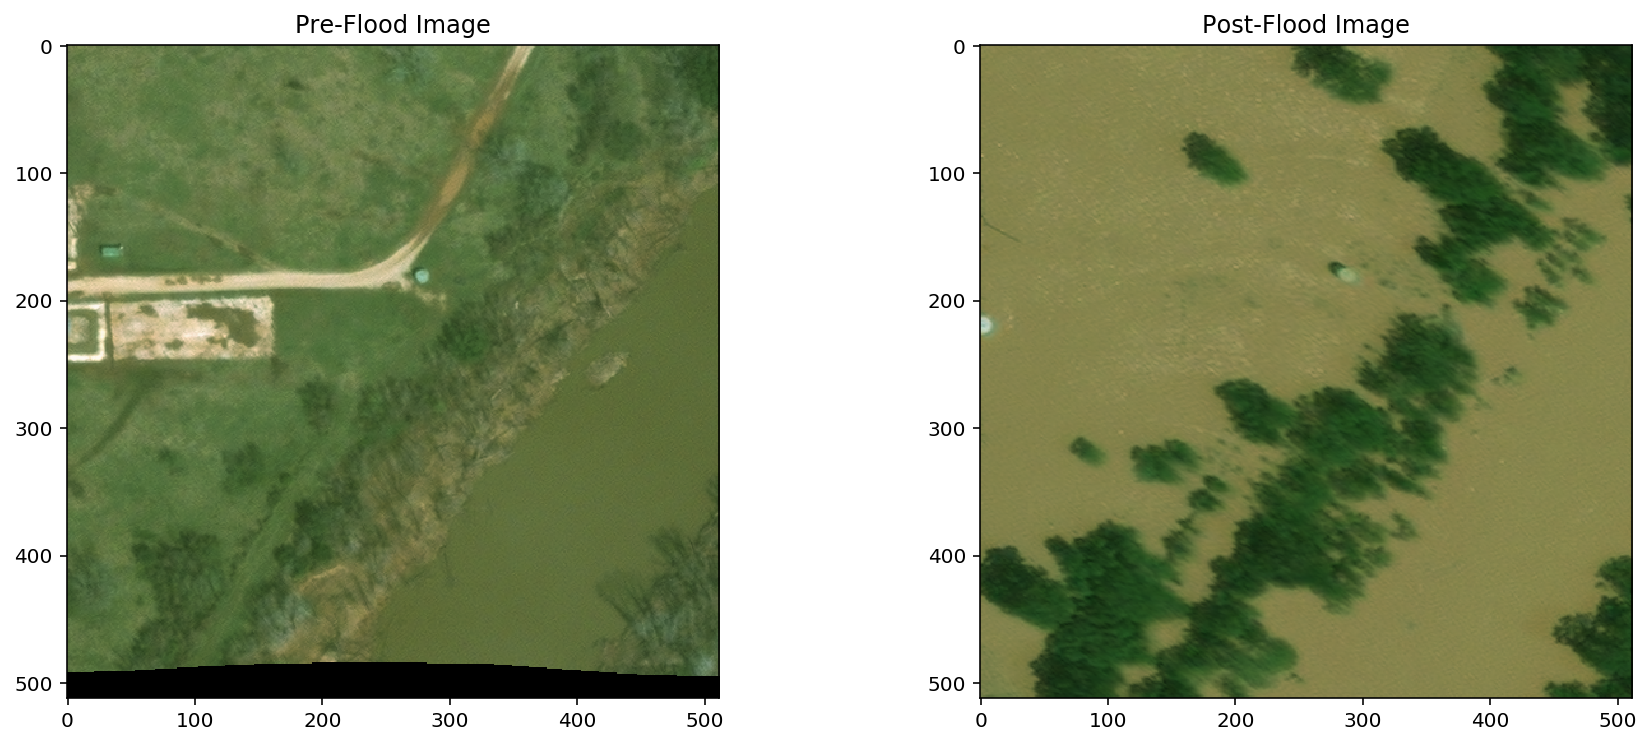

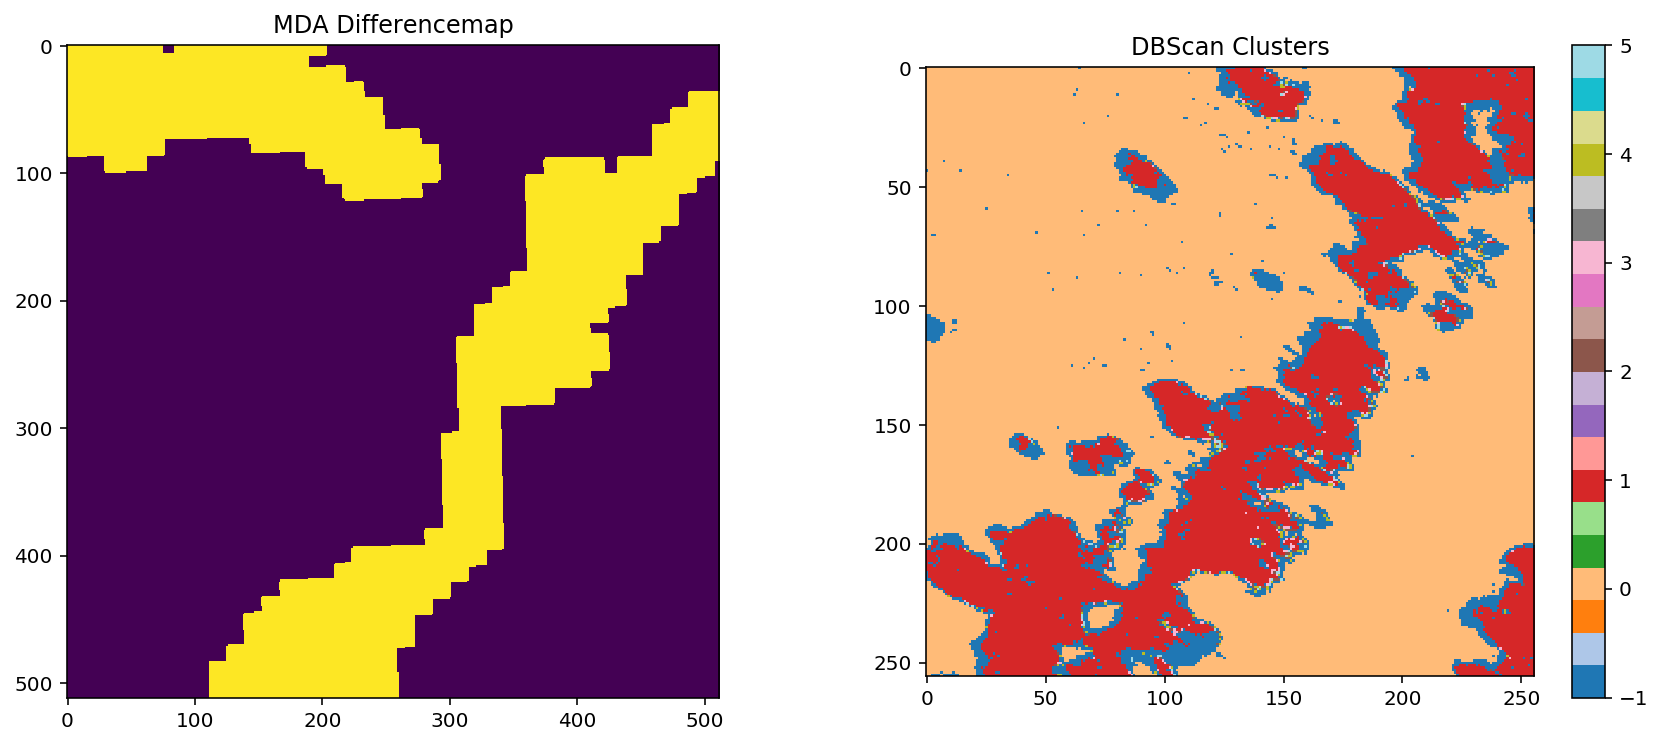

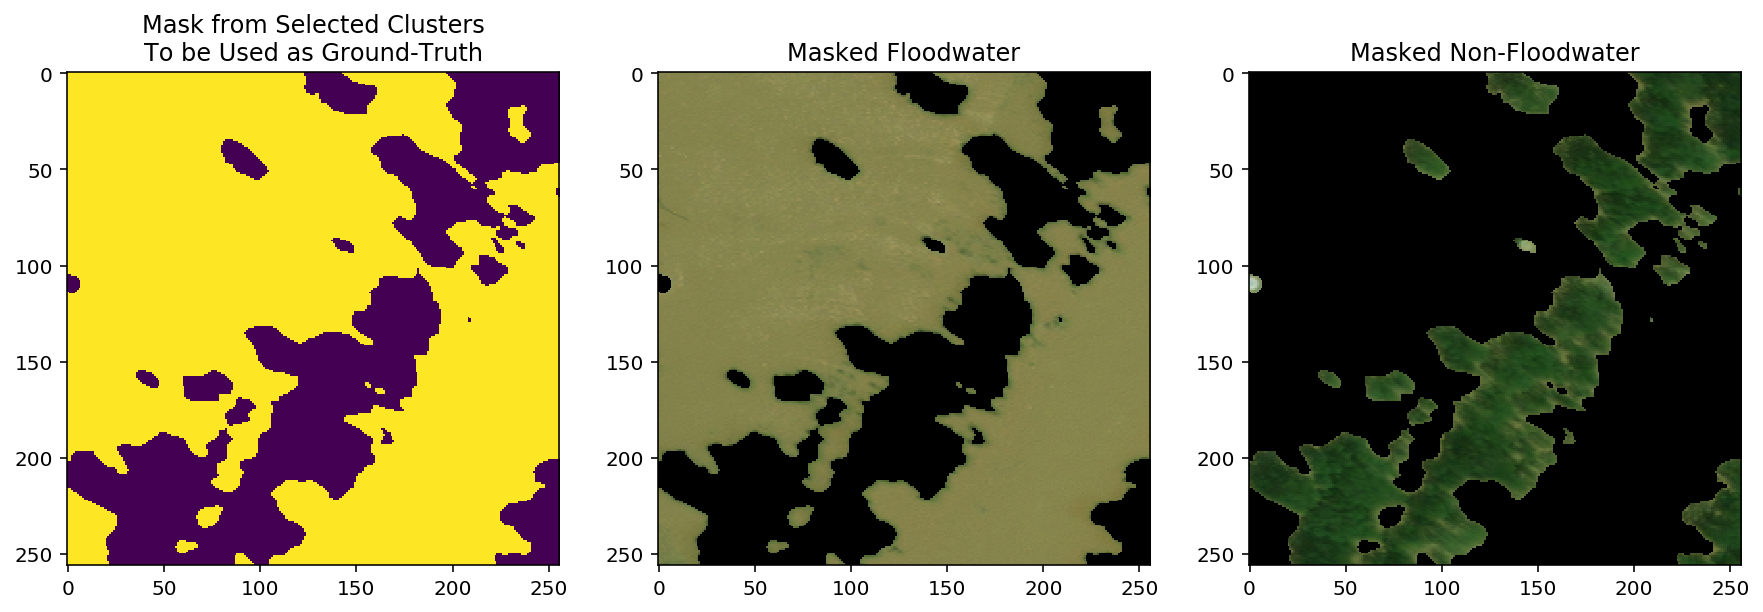

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.set_title("Pre-Flood Image")
ax2.set_title("Post-Flood Image")
ax2.axis('on')
ax1.imshow(img_pre_full)
ax2.imshow(img_post_full)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.set_title("MDA Differencemap")
ax2.set_title("DBScan Clusters")
ax1.imshow(MDA_mask)
plt.imshow(DBScan_mask,cmap='tab20')
plt.colorbar()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
ax1.set_title("Mask from Selected Clusters\nTo be Used as Ground-Truth")
ax2.set_title("Masked Floodwater")
ax3.set_title('Masked Non-Floodwater')
ax1.imshow(fine_mask)
ax2.imshow(img_post*(np.expand_dims(fine_mask==1,axis=2)) )
ax3.imshow(img_post*(np.expand_dims(fine_mask==0,axis=2)) );

#leftover code snippets

    
    print("floodwater/mud at id:",c_id)
    if dry == True: fine_mask = np.zeros((side,side),dtype='int64')  #the mask data type should match
    else: fine_mask = 1*(DBScan_mask==c_id)
    
    
    if dry == True: fine_mask = np.zeros((side,side),dtype='int64')  #the mask data type should match
    else: fine_mask = 1*(DBScan_mask==c_id)
    np.save(output_dir+"%d_256_fine_mask"%tile_no, fine_mask)

### old plotting routines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.set_title("Flood Water Only")
ax2.set_title("Flood Water removed")
ax1.imshow(img_post*(np.expand_dims(DBScan_mask==c_id,axis=2)) )
ax2.imshow(img_post*(np.expand_dims(DBScan_mask!=c_id,axis=2)));

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title("difference image")
ax2.set_title("New Image Mask(Label)")
ax3.set_title("DigitalGlobe MDA Shapefile label")
ax1.imshow(img_diff)
ax2.imshow(255.*(DBScan_mask==c_id))
ax3.imshow(mask);

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title("Post-flood Image")
ax2.set_title("DBSCAN Clusters")
ax3.set_title("Pre-flood Image")
ax1.imshow(img_post)
ax2.imshow(DBScan_mask)
ax3.imshow(img_pre);

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(18,6))
ax1.set_title("Post-flood Image")
ax2.set_title("Post-flood Image w/ mask")
ax3.set_title("Pre-flood Image")
ax4.set_title("clusters")
ax1.imshow(img_post)
ax2.imshow(img_post)
ax2.imshow(1-(DBScan_mask==c_id),cmap='bwr',alpha = 0.2)
ax3.imshow(img_pre)
plt.imshow(DBScan_mask)
plt.colorbar();